# Predicting Circle fit using emcee library

## The Problem
In this notebook, we want to be able to predict the radii, $r$, of a circle given some observed points ($x_i, y_i$) sampled along a circular path. Practically, real observations have some noise that can be attributed to systematic and/or random errors. 

From our basic understanding of geometry, we know that a circle with radius $r$ centred at ($x_c, y_c$) can be expressed, at any point ($x_i, y_i$) as follows:

$$(x_i-x_c)^2 + (y_i-y_c)^2 = r^2 $$

Based on what we know of the real world, the observed radius , $r_{obs}$ , is accompanied by some noise $\epsilon$ such that 
$r_{obs} = r + \epsilon$.

##  The Approach

To find the unknown $r, x_c , y_c $ from the data, we use the Bayesian framework to help us. In this framework, we can express the parameters as $\theta$ as a probability distribution condition upon some parameters specified by our circle expression such as the x and y coordinates as well as our measurement variance - $p(\theta |x,y,\sigma)$, which is referred to as the posterior. The likehood is represented by $p(x,y | \theta)$ while the prior, which incorporates known uncertainties about the data is denoted as $p(x,y)$

Effectively, the bayesian approach states that 

$$p(\theta |x,y,\sigma) \propto p(x,y,\sigma | \theta) \cdot p(x,y)$$

By taking samples from our posterior distribution, we can then obtain some uncertainty within the result.

## Import libraries


In [571]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import emcee
import corner


## Define a ground truth

To illustrate the bayesian approach for circle fitting, we define some arbitrary ground trutch of the property of the circle we intend to fit given some data. The ground truth will be used to evaluate the results we get.

In [613]:
# true parameters
r_opt = 10 # radius
xc_opt = 0 # center of x
yc_opt = 0 # center of y
samples = []
N = 160
angles = np.linspace(0, 2*np.pi)
xy_err = np.sqrt(2)
# define a data generating function



def preprocess(arr):
    # center the data at its mean such that xc, yc is (0,0)
    return arr - arr.mean(axis=0)


## Define a data generation function

Because we want to create some synthetic data to run our demonstration, we have to define a data generation function. 

It is effectively the equations needed to generate points (x,y) on a circle where, from the parametric form of the equation of a circle, we obtain:

$$x = x_o + r_o \, \sin(\theta)$$
$$y = y_o + r_o \, \cos(\theta)$$


In [614]:
def generate_points(x_o, y_o, r_o, theta_o):

    x_m = x_o + r_o * np.sin(theta_o)
    y_m = y_o + r_o * np.cos(theta_o)

    return np.stack((x_m, y_m), axis=1)

## The real world
We purturb the "true" coordinates with Gaussian noise ($\epsilon \sim N(0,1)$) applied at $x_i$ and $y_i$ where $i = 1,2,\dots,N$,  to get some "real" world data. We plot the Ground truth and observed coordinates in the plot below to give a view about the _messiness_ of the data. We set N to 10 whereby we pick 10 random points from the purturbed data to mimic observation points. 

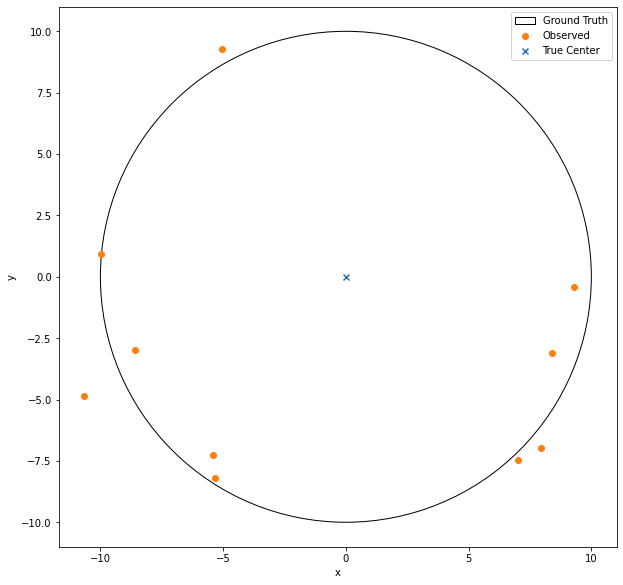

In [662]:
# perturbed coordinates
# xc_new = xc_opt + np.random.normal(0, 1)
# yc_new = yc_opt 

true_data = generate_points(xc_opt, yc_opt, r_opt, angle) 
observed_data = true_data + np.random.normal(0, 1, size=(true_data.shape[0],2))
observed_data = preprocess(observed_data) # optional step to improve result via mean centering
# select test points
num_test_points = 10
observed_data = observed_data[np.random.choice(observed_data.shape[0], size=num_test_points, replace=False), :]

fig, ax = plt.subplots(figsize=(10,10))
true_circle = plt.Circle((xc_opt, yc_opt), radius=r_opt, fill=None)
ax.add_patch(true_circle)
true_center = ax.scatter(xc_opt, yc_opt, marker="x")
scatter = ax.scatter(observed_data[:,0], observed_data[:,1], label="observed")
ax.legend([true_circle, scatter, true_center], ['Ground Truth', "Observed", "True Center"])
plt.xlabel("x")
plt.ylabel("y")
ax.axis('scaled')
plt.show()

## Define our likelihood, prior and posterior.

First, our likelihood model has to be defined. We use the approach by Keksel (2018) which assumes that the measurement model of the measured circle data deviates _radially_ from the ideal circle.  Effectively, this means that the measurement error is related to the true circle radius by the following: $\epsilon = R_{\mathrm{measured}}(x_i,y_i) - R_{\mathrm{true}}$

We assume that the measurement error, $\epsilon$, has a Gaussian distribution such that $\epsilon\sim\ \mathrm{N}(0,\sigma_{xy})$. When propagated to the measured radius, $R_{\mathrm{measured}}$,it implies that $R_{\mathrm{measured}}\sim N(R_{true},\sigma_{xy})$. Hence this can be used to define our likelihood function.

For our priors, we assume that the circle parameters $R,x_c, y_c$ are normally distributed.

In [681]:

# define our likelihood
# theta are the parameters we are looking for
# we typically know the noise covariance, and since we assume each sample is i.i.d
def log_likelihood(theta, x, y):
    r_c, x_c, y_c = theta
    model = np.sqrt((x-x_c)**2+(y-y_c)**2) # radius
    sigma2 = xy_err ** 2
    return -0.5 * np.sum(np.divide((model - r_c) ** 2 , sigma2) + np.log(2*np.pi*sigma2))

def log_prior(theta, x, y):
    r_c, x_c, y_c = theta
    r = np.sqrt(x**2 + y**2)
    sigma_r = 10 # we "guess" the variance in the radius
    return - (((r_c - r) / sigma_r) + (x_c-x) + (y_c-y))

def log_probability(theta, x, y):
    lp = log_prior(theta, x, y)

    return lp + log_likelihood(theta, x, y) # add likelihood due to log


In [682]:

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args) # maximise the log likelihood
initial = np.array([r_opt, xc_opt, yc_opt]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(observed_data[:,0], observed_data[:,1]))
r_ml, x_ml, y_ml = soln.x

print("Maximum likelihood estimates:")
print("r = {0:.3f}".format(r_ml))
print("x_c = {0:.3f}".format(x_ml))
print("y_c = {0:.3f}".format(y_ml))


Maximum likelihood estimates:
r = 9.981
x_c = -0.206
y_c = 0.228


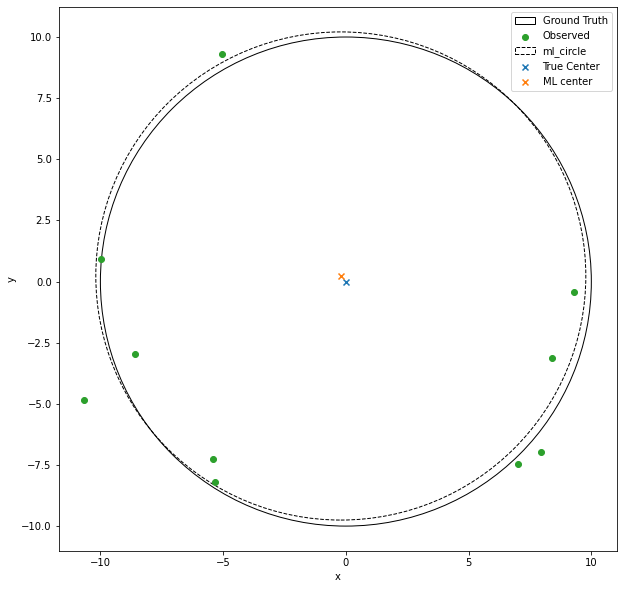

In [683]:
ml_circle = plt.Circle((x_ml, y_ml), radius=r_ml, fill=None, linestyle='--')
fig, ax1 = plt.subplots(figsize=(10,10))
true_circle = plt.Circle((xc_opt, yc_opt), radius=r_opt, fill=None)
true_center = ax1.scatter(xc_opt, yc_opt, marker="x")
ml_center = ax1.scatter(x_ml, y_ml, marker="x")
ax1.add_patch(true_circle)
ax1.add_patch(ml_circle)
observed = ax1.scatter(observed_data[:,0], observed_data[:,1], label="observed")
ax1.legend([true_circle, observed, ml_circle, true_center, ml_center], ['Ground Truth', "Observed", "ml_circle", "True Center", "ML center"])
plt.xlabel("x")
plt.ylabel("y")
ax.axis('scaled')
plt.show()


## Sampling using the MCMC sampler

In [684]:

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(observed_data[:,0], observed_data[:,1])
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:07<00:00, 688.55it/s]


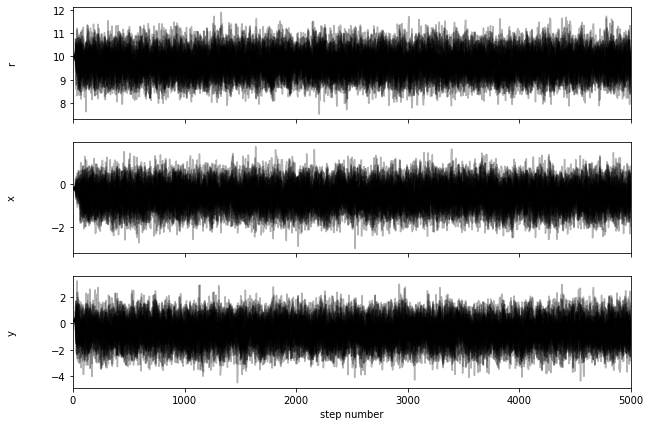

In [685]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["r", "x", "y"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [686]:
tau = sampler.get_autocorr_time()
print(tau) # 40 steps for burn in

[35.60655833 38.51604621 34.95114619]


In [687]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True) # discard initial 100 steps, thin half autocorrelation time, and flatten chain
print(flat_samples.shape)

(8512, 3)


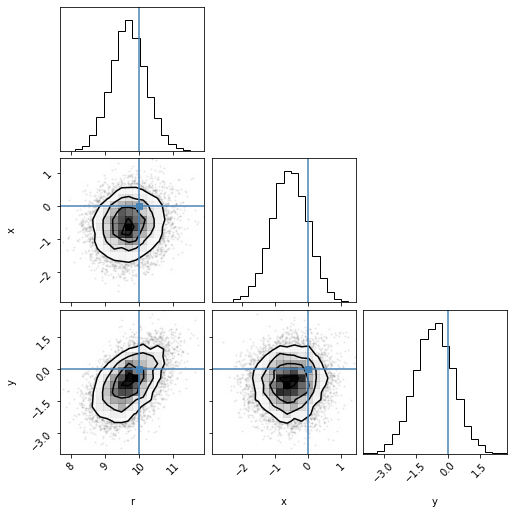

In [688]:


fig = corner.corner(
    flat_samples, labels=labels, truths=[r_opt, xc_opt, yc_opt]
); #That means

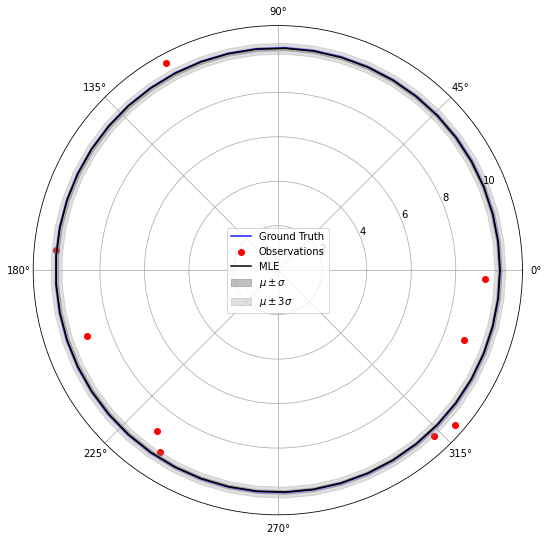

In [692]:
observed_theta = np.arctan2(observed_data[:,1],observed_data[:,0])
observed_radii = np.sqrt(observed_data[:,1]**2 + observed_data[:,0]**2)
plt.figure(figsize=(16, 9))
ax = plt.subplot(111, polar=True)
paths = plt.polar(angles, np.repeat(r_opt, angles.shape[0]), color="b", alpha=0.9, label="Ground Truth")
plt.scatter(observed_theta, observed_radii, color="r", alpha=1, label="Observations")
plt.polar(angles,np.repeat(r_m, angles.shape[0]), label="MLE", color="black")
plt.fill_between(
    angles,
    np.repeat(r_m - x_sigma, angles.shape[0]),
    np.repeat(r_m + x_sigma, angles.shape[0]),
    color="gray",
    alpha=0.5,
    label=r"$\mu\pm\sigma$",
)
plt.fill_between(
    angles,
    np.repeat(r_m - 3* x_sigma, angles.shape[0]),
    np.repeat(r_m + 3 * x_sigma, angles.shape[0]),
    color="gray",
    alpha=0.25,
    label=r"$\mu\pm3\sigma$",
)
ax.set_ylim(0,11)
plt.legend()
plt.show()